# HOME CREDIT SCORE CARD MODEL

## Load Dataset

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest #feature selection
from sklearn.feature_selection import chi2
from sklearn.utils import resample #re-sampling
from sklearn.model_selection import train_test_split #data splitting
from sklearn.preprocessing import StandardScaler #normalize features

from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.naive_bayes import GaussianNB #gaussian naive bayes
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #decision tree
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.neighbors import KNeighborsClassifier #k-nearest neighbor
from sklearn.neural_network import MLPClassifier #neural network
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_auc_score #roc score

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Main Dataset

#### Data Application (Train)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Home Credit VIX/dataset homecredit/application_train.csv')
df

Mounted at /content/drive


There are total 307,511 rows which contains the information of loans and there are 122 features.

The `TARGET` feature defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as 1 while other all other cases as 0.

## Exploratory Data Analysis (EDA)

### Check Data Types

In [4]:
print('Data types: \n')
df.info(verbose=True)

Data types: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    in

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


### Visualization

In [6]:
train = df.copy()

#### Univearite : The Number of Customers Based on Their Repayment Abilities

In [7]:
decode_map = {0: "No Payment Difficulties", 1: "Payment Difficulties"}
def decode_sentiment(label):
    return decode_map[int(label)]

train['TARGET'] = train['TARGET'].apply(lambda x: decode_sentiment(x))

In [8]:
target_grp = (train[['TARGET']]
                .groupby("TARGET")
                .agg(COUNT=("TARGET","count"))
                .sort_values(by=["COUNT"],ascending=False)
                .reset_index()
                )

target_grp

,TARGET,COUNT
0,No Payment Difficulties,282686
1,Payment Difficulties,24825


In [9]:
grp = train['TARGET'].value_counts(normalize=True)
grp.reset_index()

,index,TARGET
0,No Payment Difficulties,0.919271
1,Payment Difficulties,0.080729


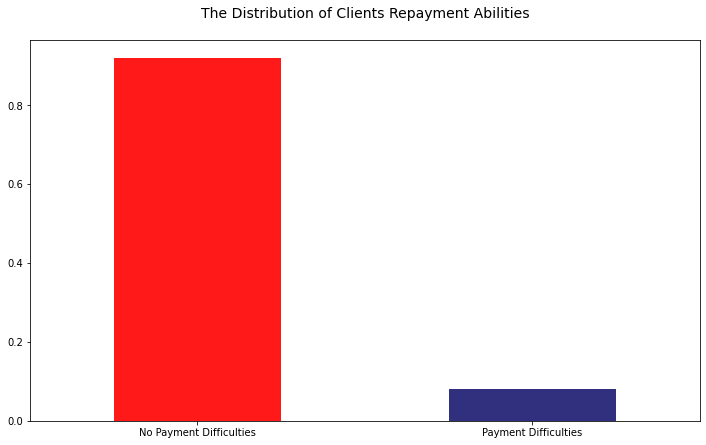

In [10]:
fig = plt.figure(figsize = (12,7))
grp.plot(kind='bar', color= ['red','midnightblue'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.show()

There are about 91% loans which is equal to about 282K with `TARGET` = 0, which indicates that client did not had any problems in repaying the loan in given time. While only 9% of the total loans (about 24K applicants) in this dataset involved the clients having problems in repaying the loan.

**Note**: This dataset is imbalanced and it does require special treatment or resampling. The resampling step will be carried out in the model building section.

#### Bivariate: Categorical Features Vs Target

##### Contract Type, Gender, Car Ownership Status, and Realty Ownership Status

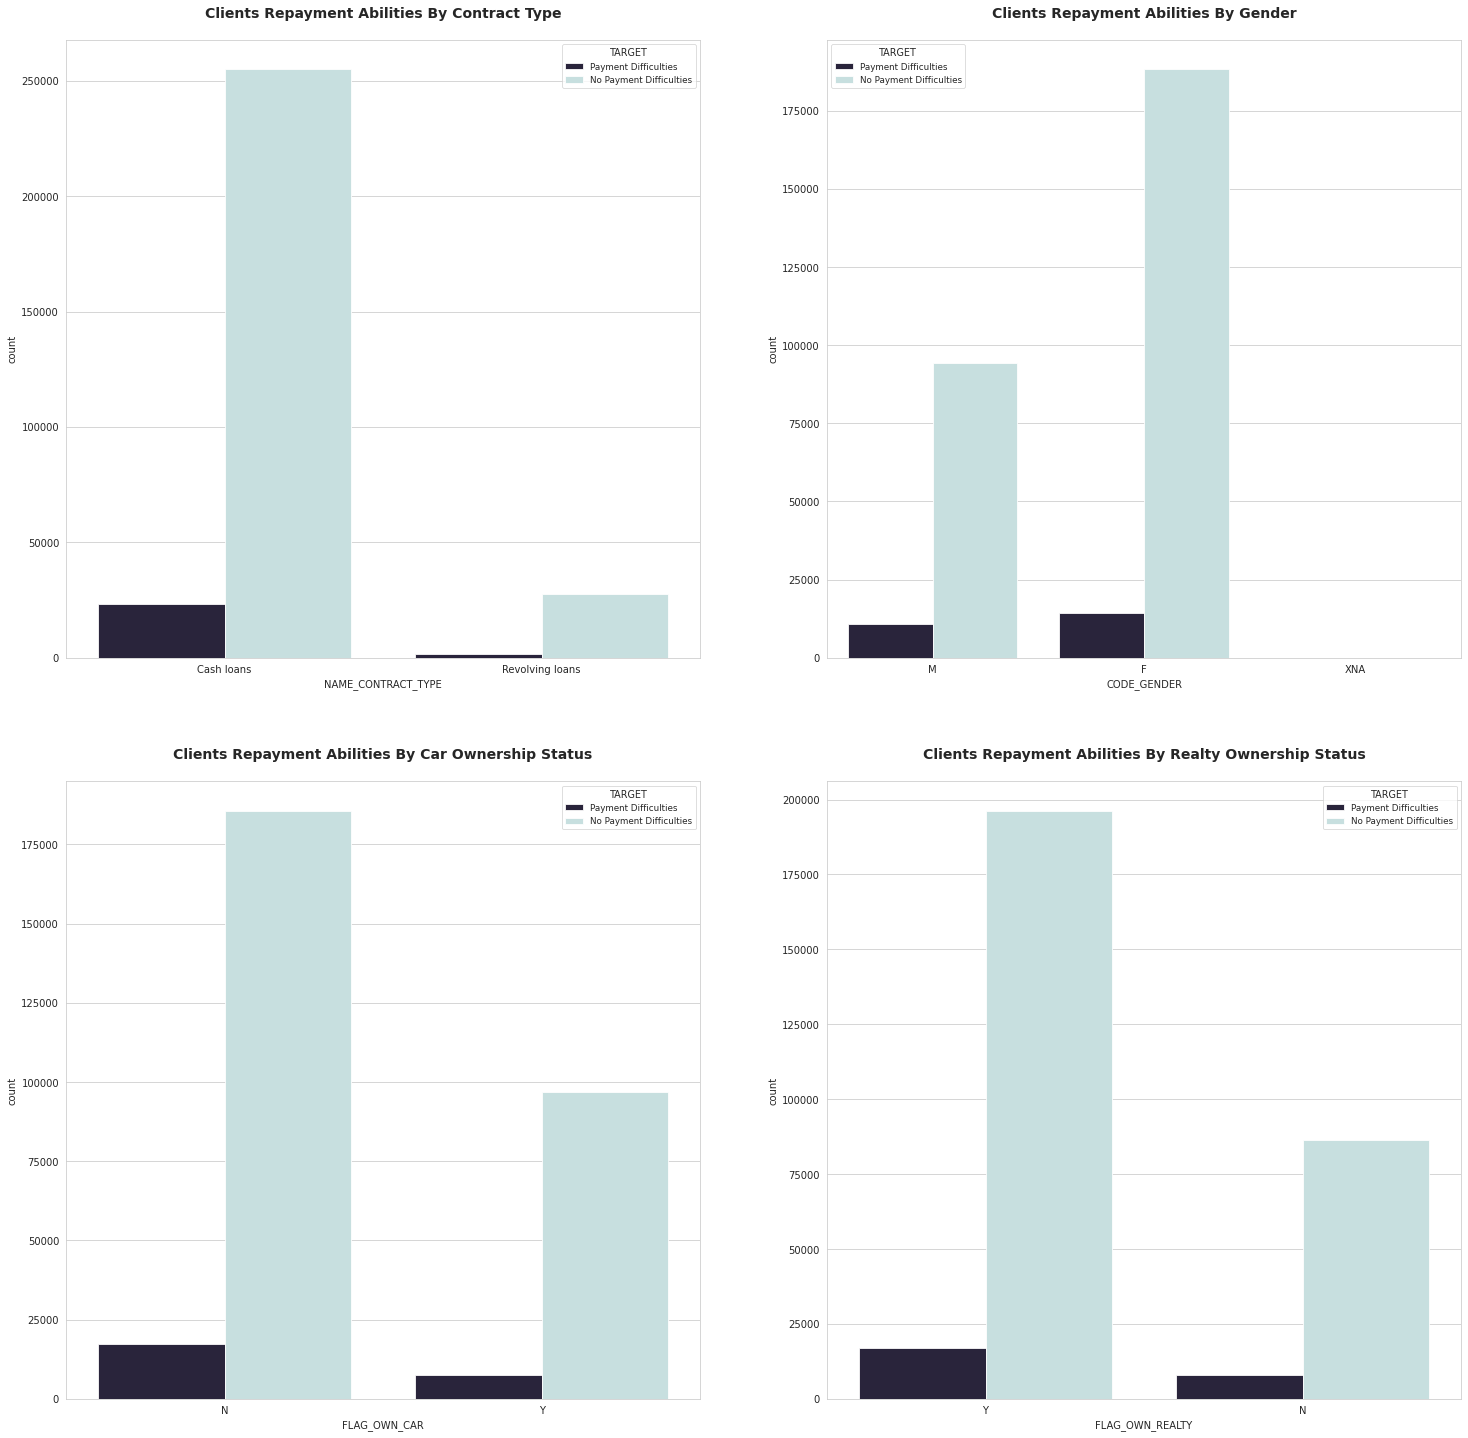

In [11]:
# visualization pt 1
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,25))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Contract Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_CONTRACT_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Gender\n', fontweight='bold', fontsize=14)
sns.countplot(x='CODE_GENDER', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Car Ownership Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='FLAG_OWN_CAR', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Realty Ownership Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='FLAG_OWN_REALTY', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][1])

##### Contract Type Vs Target

In [12]:
ct = train.groupby(by=['NAME_CONTRACT_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Contract Type')
ct.sort_values(by='SK_ID_CURR', ascending=False)
ct

Clients Repayment Abilities By Contract Type


,NAME_CONTRACT_TYPE,TARGET,SK_ID_CURR
0,Cash loans,No Payment Difficulties,255011
1,Cash loans,Payment Difficulties,23221
2,Revolving loans,No Payment Difficulties,27675
3,Revolving loans,Payment Difficulties,1604


**Cash loans** with around 278K loans accounted for the majority of total loans in this dataset. **Revolving loans** have a much lower amount of around 29K compared to cash loans.

##### Gender Vs Target

In [13]:
train['CODE_GENDER'] = train['CODE_GENDER'].replace(['F','M'],['Female','Male'])

In [14]:
gt = train.groupby(by=['CODE_GENDER','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Gender')
gt.sort_values(by='SK_ID_CURR', ascending=False)
gt

Clients Repayment Abilities By Gender


,CODE_GENDER,TARGET,SK_ID_CURR
0,Female,No Payment Difficulties,188278
1,Female,Payment Difficulties,14170
2,Male,No Payment Difficulties,94404
3,Male,Payment Difficulties,10655
4,XNA,No Payment Difficulties,4


In [15]:
df[['CODE_GENDER','TARGET']].groupby(['CODE_GENDER'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,CODE_GENDER,TARGET
1,M,0.101419
0,F,0.069993
2,XNA,0.000000


It can be seen that women have applied for a larger majority of loans. In total, there are about 202,448 loan applications applied by women, and about 105,059 applications applied by men. 

However, a larger percentage (about 10% of the total) of **men** had the problems repaying the loan compared to women clients (about 7%).

##### Car Ownership Status Vs Target

In [16]:
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace(['Y','N'],['Yes','No'])

In [17]:
ot = train.groupby(by=['FLAG_OWN_CAR','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Car Ownership Status')
ot.sort_values(by='SK_ID_CURR', ascending=False)
ot

Clients Repayment Abilities By Car Ownership Status


,FLAG_OWN_CAR,TARGET,SK_ID_CURR
0,No,No Payment Difficulties,185675
1,No,Payment Difficulties,17249
2,Yes,No Payment Difficulties,97011
3,Yes,Payment Difficulties,7576


In [18]:
df[['FLAG_OWN_CAR','TARGET']].groupby(['FLAG_OWN_CAR'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_CAR,TARGET
0,N,0.085002
1,Y,0.072437


Most of the clients do not own a car.

Clients who **own a car** (about 8%) had the problems in repaying the loan compared to clients who not own a car (about 7%). However, the difference is not very significant.

##### Realty Ownership Status Vs Target

In [19]:
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace(['Y','N'],['Yes','No'])

In [20]:
rt = train.groupby(by=['FLAG_OWN_REALTY','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Realty Ownership Status')
rt.sort_values(by='SK_ID_CURR', ascending=False)
rt

Clients Repayment Abilities By Realty Ownership Status


,FLAG_OWN_REALTY,TARGET,SK_ID_CURR
0,No,No Payment Difficulties,86357
1,No,Payment Difficulties,7842
2,Yes,No Payment Difficulties,196329
3,Yes,Payment Difficulties,16983


In [21]:
df[['FLAG_OWN_REALTY','TARGET']].groupby(['FLAG_OWN_REALTY'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_REALTY,TARGET
0,N,0.083249
1,Y,0.079616


Most of the clients own a flat/house.

Clients who **own a house/flat** (about 8%) had the problems in repaying the loan compared to clients who not own a house/flat (about 7%). However, the difference is not very significant.

##### Suite Type, Income Type, Education Type, and Family Status

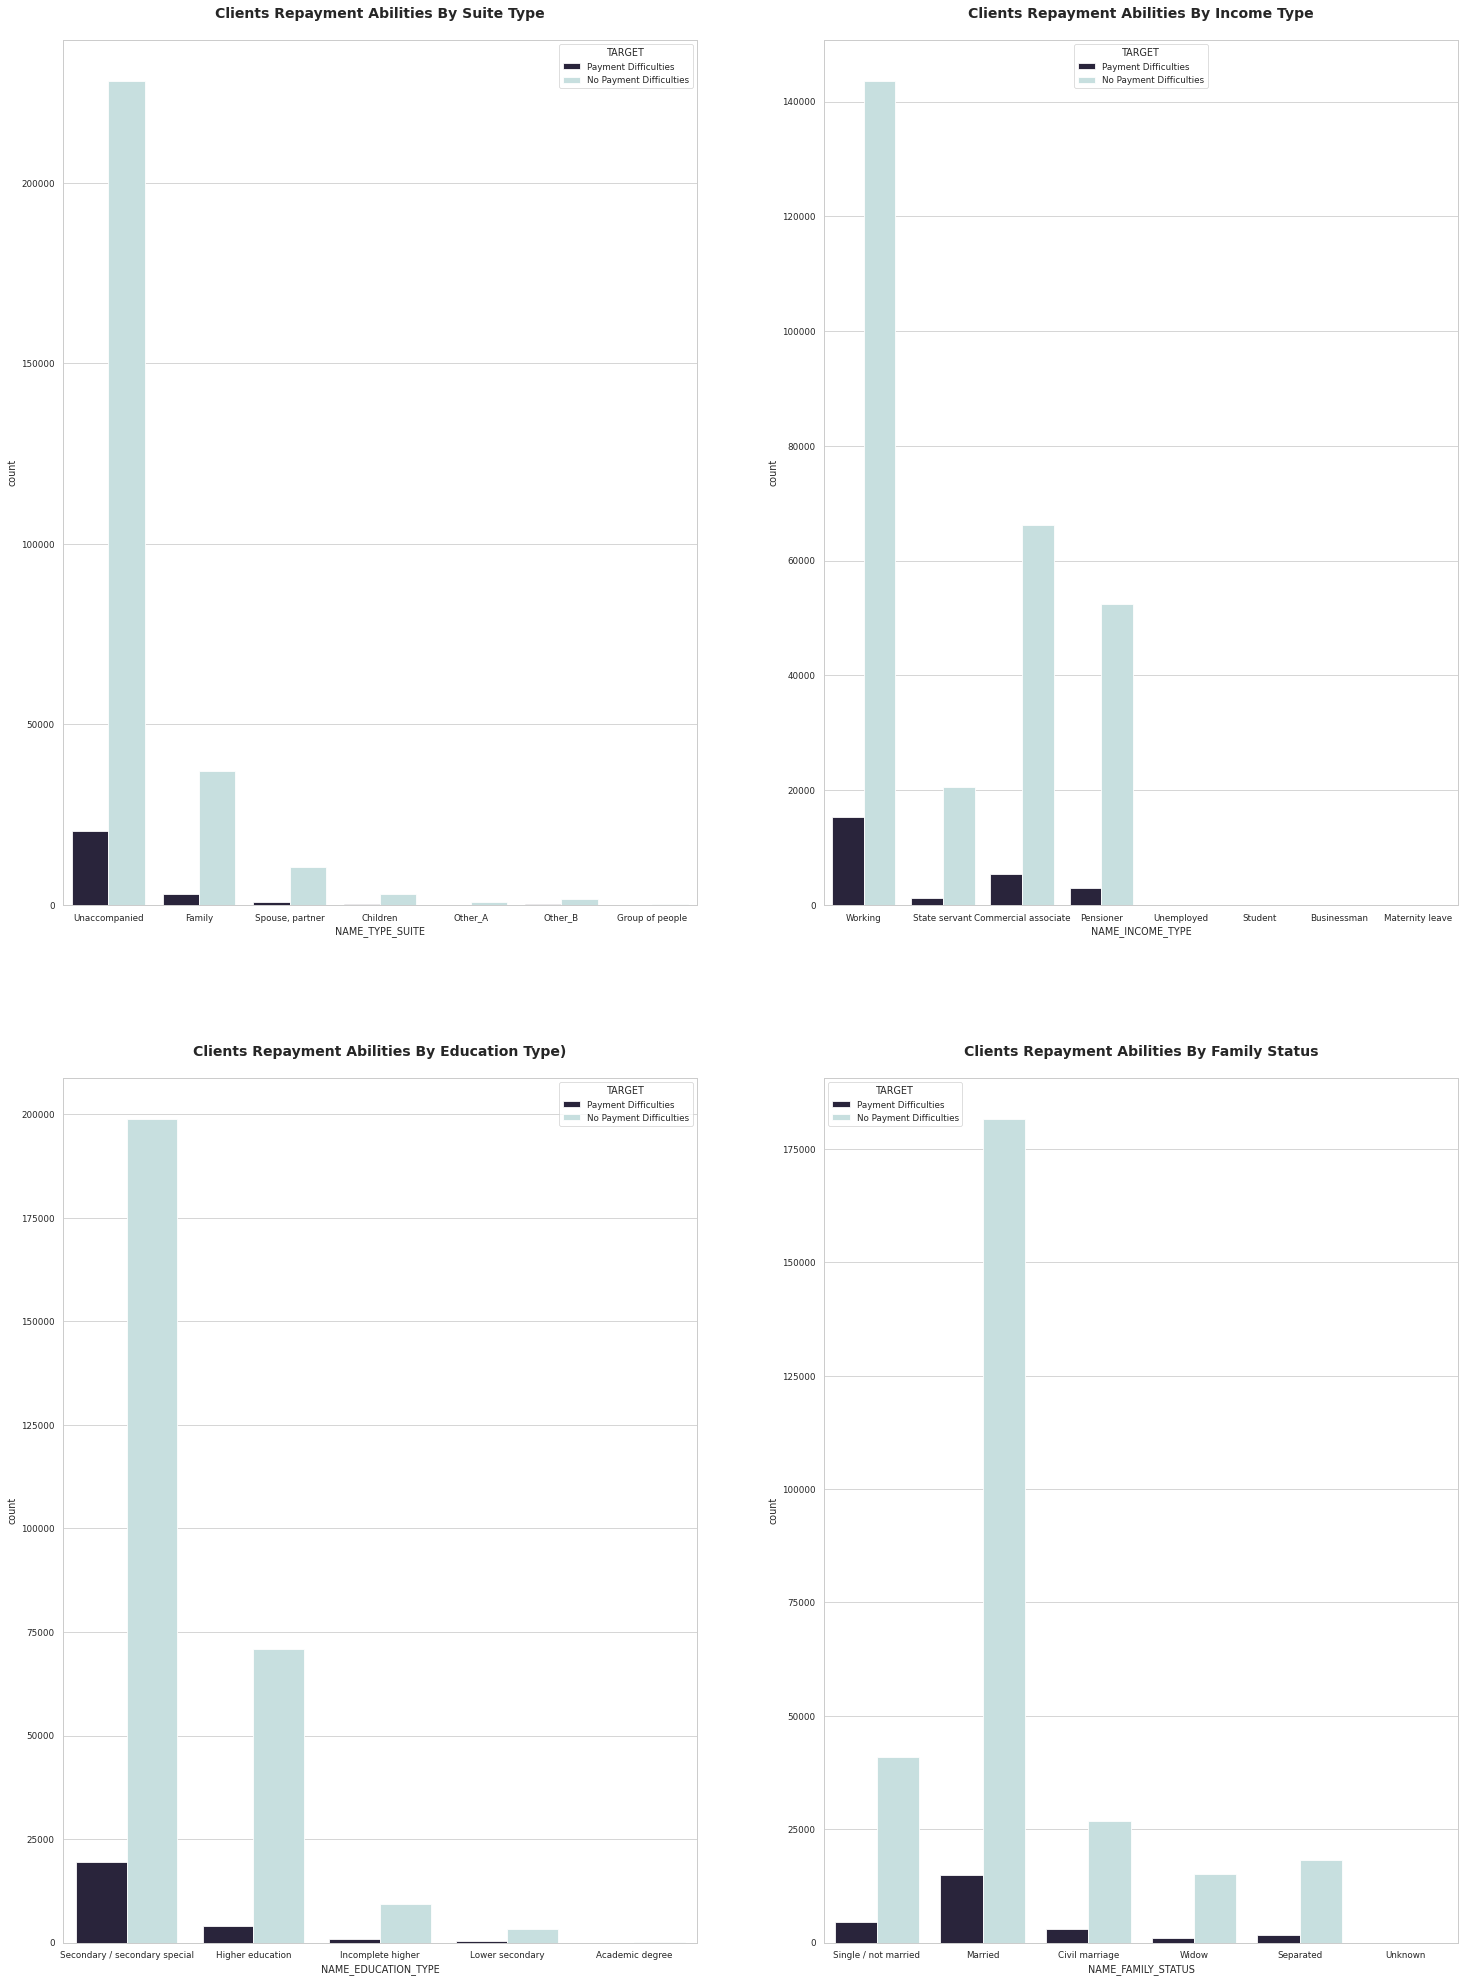

In [22]:
# visualization pt. 2
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,35))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Suite Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_TYPE_SUITE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Income Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_INCOME_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Education Type)\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_EDUCATION_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Family Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_FAMILY_STATUS', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][1])

##### Suite Type Vs Target

In [23]:
st = train.groupby(by=['NAME_TYPE_SUITE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Suite Type')
st.sort_values(by='SK_ID_CURR', ascending=False)
st

Clients Repayment Abilities By Suite Type


,NAME_TYPE_SUITE,TARGET,SK_ID_CURR
0,Children,No Payment Difficulties,3026
1,Children,Payment Difficulties,241
2,Family,No Payment Difficulties,37140
3,Family,Payment Difficulties,3009
4,Group of people,No Payment Difficulties,248
5,Group of people,Payment Difficulties,23
6,Other_A,No Payment Difficulties,790
7,Other_A,Payment Difficulties,76
8,Other_B,No Payment Difficulties,1596
9,Other_B,Payment Difficulties,174


In [24]:
df[['NAME_TYPE_SUITE','TARGET']].groupby(['NAME_TYPE_SUITE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_TYPE_SUITE,TARGET
4,Other_B,0.098305
3,Other_A,0.087760
2,Group of people,0.084871
6,Unaccompanied,0.081830
5,"Spouse, partner",0.078716
1,Family,0.074946
0,Children,0.073768


Clients who are accompanied by **other_b** when applying for a loan have a higher percentage of having difficulty repaying the loan (about 10%).

##### Income Type Vs Target

In [25]:
rt = train.groupby(by=['NAME_INCOME_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Income Type')
rt.sort_values(by='SK_ID_CURR', ascending=False)
rt

Clients Repayment Abilities By Income Type


,NAME_INCOME_TYPE,TARGET,SK_ID_CURR
0,Businessman,No Payment Difficulties,10
1,Commercial associate,No Payment Difficulties,66257
2,Commercial associate,Payment Difficulties,5360
3,Maternity leave,No Payment Difficulties,3
4,Maternity leave,Payment Difficulties,2
5,Pensioner,No Payment Difficulties,52380
6,Pensioner,Payment Difficulties,2982
7,State servant,No Payment Difficulties,20454
8,State servant,Payment Difficulties,1249
9,Student,No Payment Difficulties,18


In [26]:
df[['NAME_INCOME_TYPE','TARGET']].groupby(['NAME_INCOME_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_INCOME_TYPE,TARGET
2,Maternity leave,0.400000
6,Unemployed,0.363636
7,Working,0.095885
1,Commercial associate,0.074843
4,State servant,0.057550
3,Pensioner,0.053864
0,Businessman,0.000000
5,Student,0.000000


It can be seen that clients who have income type of working have applied for a larger majority of loans, there are about 158,774 loan applications.

Clients with the income type of businessman and student have no difficulty in repaying their loans. 

While, clients with the income type of **maternity leaves** and **unemployed** have the highest percentage (about 40% and 36%) of `TARGET` = 1, ie. having problem in repaying the loans.

##### Education Type Vs Target

In [27]:
et = train.groupby(by=['NAME_EDUCATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Education Type')
et.sort_values(by='SK_ID_CURR', ascending=False)
et

Clients Repayment Abilities By Education Type


,NAME_EDUCATION_TYPE,TARGET,SK_ID_CURR
0,Academic degree,No Payment Difficulties,161
1,Academic degree,Payment Difficulties,3
2,Higher education,No Payment Difficulties,70854
3,Higher education,Payment Difficulties,4009
4,Incomplete higher,No Payment Difficulties,9405
5,Incomplete higher,Payment Difficulties,872
6,Lower secondary,No Payment Difficulties,3399
7,Lower secondary,Payment Difficulties,417
8,Secondary / secondary special,No Payment Difficulties,198867
9,Secondary / secondary special,Payment Difficulties,19524


In [28]:
df[['NAME_EDUCATION_TYPE','TARGET']].groupby(['NAME_EDUCATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_EDUCATION_TYPE,TARGET
3,Lower secondary,0.109277
4,Secondary / secondary special,0.089399
2,Incomplete higher,0.084850
1,Higher education,0.053551
0,Academic degree,0.018293


A large number of applications (218K) are filed by client having secondary education followed by people with higher education with 75K applications. 

While, it can be seen that the clients with the education type of **lower secondary** has the highest percentage (around 10%) of `TARGET` = 1, ie. having problem in repaying the loans.

#####  Family Status Vs Target

In [29]:
ft = train.groupby(by=['NAME_FAMILY_STATUS','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Family Status')
ft.sort_values(by='SK_ID_CURR', ascending=False)
ft

Clients Repayment Abilities By Family Status


,NAME_FAMILY_STATUS,TARGET,SK_ID_CURR
0,Civil marriage,No Payment Difficulties,26814
1,Civil marriage,Payment Difficulties,2961
2,Married,No Payment Difficulties,181582
3,Married,Payment Difficulties,14850
4,Separated,No Payment Difficulties,18150
5,Separated,Payment Difficulties,1620
6,Single / not married,No Payment Difficulties,40987
7,Single / not married,Payment Difficulties,4457
8,Unknown,No Payment Difficulties,2
9,Widow,No Payment Difficulties,15151


In [30]:
df[['NAME_FAMILY_STATUS','TARGET']].groupby(['NAME_FAMILY_STATUS'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_FAMILY_STATUS,TARGET
0,Civil marriage,0.099446
3,Single / not married,0.098077
2,Separated,0.081942
1,Married,0.075599
5,Widow,0.058242
4,Unknown,0.000000


It can be seen that clients who are married have applied for a larger majority of loans, there are about 196,432 loan applications.

Clients with family status of **civil marriage** and **single** have the highest percentage (around 9%) of clients who have problem in repaying the loans.

##### Housing Type, Occupation Type, Process Day, and Organization Type

##### Housing Type Vs Target

In [31]:
ht = train.groupby(by=['NAME_HOUSING_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Housing Type')
ht.sort_values(by='SK_ID_CURR', ascending=False)
ht

Clients Repayment Abilities By Housing Type


,NAME_HOUSING_TYPE,TARGET,SK_ID_CURR
0,Co-op apartment,No Payment Difficulties,1033
1,Co-op apartment,Payment Difficulties,89
2,House / apartment,No Payment Difficulties,251596
3,House / apartment,Payment Difficulties,21272
4,Municipal apartment,No Payment Difficulties,10228
5,Municipal apartment,Payment Difficulties,955
6,Office apartment,No Payment Difficulties,2445
7,Office apartment,Payment Difficulties,172
8,Rented apartment,No Payment Difficulties,4280
9,Rented apartment,Payment Difficulties,601


In [32]:
df[['NAME_HOUSING_TYPE','TARGET']].groupby(['NAME_HOUSING_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_HOUSING_TYPE,TARGET
4,Rented apartment,0.123131
5,With parents,0.116981
2,Municipal apartment,0.085397
0,Co-op apartment,0.079323
1,House / apartment,0.077957
3,Office apartment,0.065724


It can be seen that the clients with housing type of **rented apartment** has the highest percentage (around 12%) in difficulty in repaying the loans.

Text(0.5, 0, '\nHousing Type')

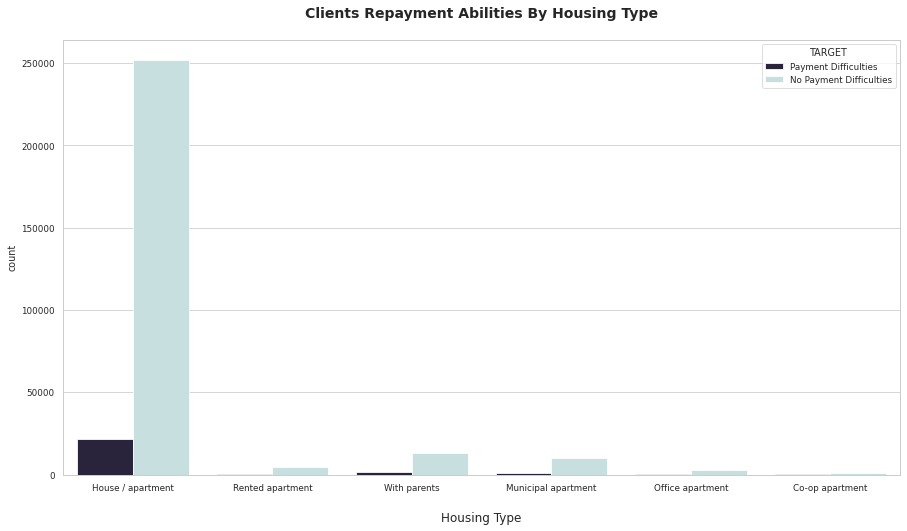

In [33]:
# visualization
plt.figure(figsize=(15,8))
fig = sns.countplot(x='NAME_HOUSING_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r')
plt.title('Clients Repayment Abilities By Housing Type\n', fontweight='bold', fontsize=14)
plt.xlabel('\nHousing Type', fontsize=12)

Clients living in **House / apartments** has the highest number of loan apllications equal to 272K.

##### Occupation Type Vs Target

In [35]:
ot = train.groupby(by=['OCCUPATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Occupation Type')
ot.sort_values(by='SK_ID_CURR', ascending=False)
ot

Clients Repayment Abilities By Occupation Type


,OCCUPATION_TYPE,TARGET,SK_ID_CURR
0,Accountants,No Payment Difficulties,9339
1,Accountants,Payment Difficulties,474
2,Cleaning staff,No Payment Difficulties,4206
3,Cleaning staff,Payment Difficulties,447
4,Cooking staff,No Payment Difficulties,5325
5,Cooking staff,Payment Difficulties,621
6,Core staff,No Payment Difficulties,25832
7,Core staff,Payment Difficulties,1738
8,Drivers,No Payment Difficulties,16496
9,Drivers,Payment Difficulties,2107


In [ ]:
df[['OCCUPATION_TYPE','TARGET']].groupby(['OCCUPATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,OCCUPATION_TYPE,TARGET
9,Low-skill Laborers,0.171524
4,Drivers,0.113261
17,Waiters/barmen staff,0.112760
16,Security staff,0.107424
8,Laborers,0.105788
2,Cooking staff,0.104440
14,Sales staff,0.096318
1,Cleaning staff,0.096067
13,Realty agents,0.078562
15,Secretaries,0.070498


A large number of applications (55K) are filed by clients who work as Laborers.

It can be seen that the clients with occupation type of **Low-skill Laborers** has the highest percentage (around 17%) of `TARGET` = 1, ie. having problem in repaying the loans.

##### Process Day Vs Target

In [ ]:
pt = train.groupby(by=['WEEKDAY_APPR_PROCESS_START','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Process Day')
pt.sort_values(by='SK_ID_CURR', ascending=False)
pt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Process Day


,WEEKDAY_APPR_PROCESS_START,TARGET,SK_ID_CURR
0,FRIDAY,No Payment Difficulties,46237
1,FRIDAY,Payment Difficulties,4101
2,MONDAY,No Payment Difficulties,46780
3,MONDAY,Payment Difficulties,3934
4,SATURDAY,No Payment Difficulties,31182
5,SATURDAY,Payment Difficulties,2670
6,SUNDAY,No Payment Difficulties,14898
7,SUNDAY,Payment Difficulties,1283
8,THURSDAY,No Payment Difficulties,46493
9,THURSDAY,Payment Difficulties,4098


In [ ]:
d[['WEEKDAY_APPR_PROCESS_START','TARGET']].groupby(['WEEKDAY_APPR_PROCESS_START'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,WEEKDAY_APPR_PROCESS_START,TARGET
5,TUESDAY,0.083505
6,WEDNESDAY,0.081604
0,FRIDAY,0.081469
4,THURSDAY,0.081003
3,SUNDAY,0.079291
2,SATURDAY,0.078873
1,MONDAY,0.077572


Text(0.5, 0, '\nProcess Day')

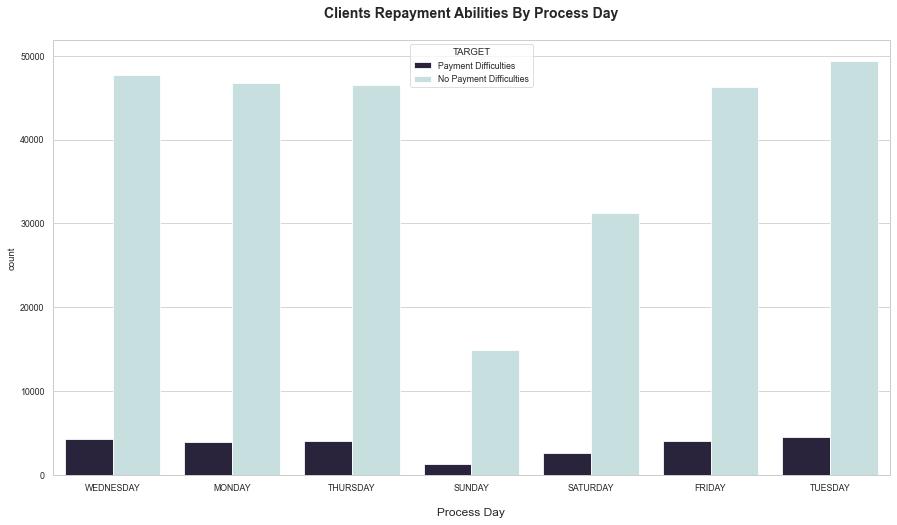

In [ ]:
# visualization
plt.figure(figsize=(15,8))
fig = sns.countplot(x='WEEKDAY_APPR_PROCESS_START', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r')
plt.title('Clients Repayment Abilities By Process Day\n', fontweight='bold', fontsize=14)
plt.xlabel('\nProcess Day', fontsize=12)

It can be seen that each application processing day has almost the same percentage (about 7% - 8%) in of `TARGET` = 1, ie. having problem in repaying the loans.

##### Organization Type Vs Target

In [ ]:
tt = train.groupby(by=['ORGANIZATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Suite Type')
tt.sort_values(by='SK_ID_CURR', ascending=False)
tt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Suite Type


,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
0,Advertising,No Payment Difficulties,394
1,Advertising,Payment Difficulties,35
2,Agriculture,No Payment Difficulties,2197
3,Agriculture,Payment Difficulties,257
4,Bank,No Payment Difficulties,2377
5,Bank,Payment Difficulties,130
6,Business Entity Type 1,No Payment Difficulties,5497
7,Business Entity Type 1,Payment Difficulties,487
8,Business Entity Type 2,No Payment Difficulties,9653
9,Business Entity Type 2,Payment Difficulties,900


In [ ]:
df[['ORGANIZATION_TYPE','TARGET']].groupby(['ORGANIZATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,ORGANIZATION_TYPE,TARGET
54,Transport: type 3,0.157540
18,Industry: type 13,0.134328
25,Industry: type 8,0.125000
38,Restaurant,0.117062
7,Construction,0.116798
6,Cleaning,0.111538
14,Industry: type 1,0.110683
20,Industry: type 3,0.106162
36,Realtor,0.106061
1,Agriculture,0.104727


It can be seen that the clients with organization type of **transport: type 3** has the highest percentage (around 15%) of `TARGET` = 1, ie. having problem in repaying the loans.

#### Bivariate: Numerical Features Vs Target

##### Amount Credit of the Loan Vs Target

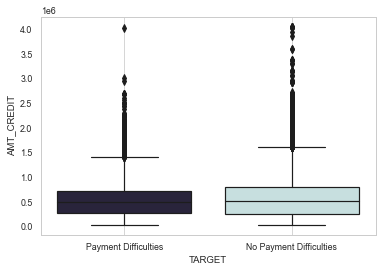

In [ ]:
sns.boxplot(x='TARGET', y='AMT_CREDIT', data=train, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

It can be seen that median value of the credit amount of the clients who have no payment difficulties is slightly larger than the median value of clients who have payment difficulties. It means, the clients with higher credit amount of the loan have a slightly higher chances of being capable of repaying the loan than clients with lower credit amount.

##### Amount Income Vs Target

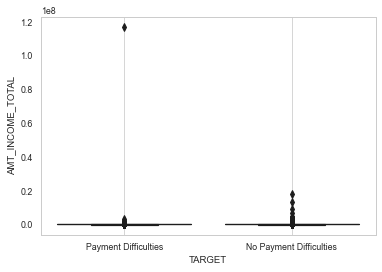

In [ ]:
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=train, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

It can be seen that both clients who have payment difficulties as well as clients who have no payment difficulties, have mostly the same value.
However, as the client's income increases, the probability that cliets will not have difficulty repaying the loan also increases.

##### Age Vs target

In [ ]:
no_age = df[df['TARGET']==0]['DAYS_BIRTH'].values/-365
yes_age = df[df['TARGET']==1]['DAYS_BIRTH'].values/-365

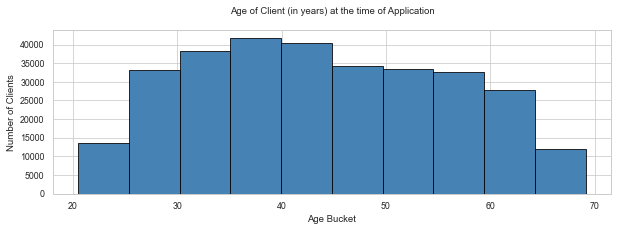

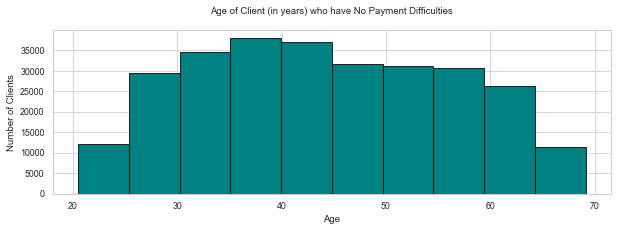

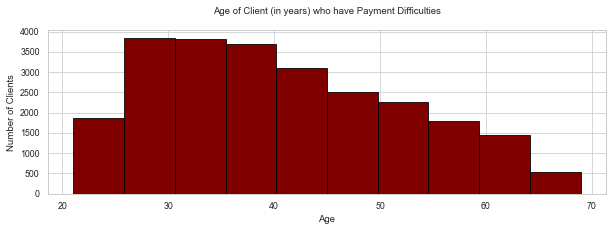

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(df['DAYS_BIRTH'].values/-365, bins=10, edgecolor='black', color='steelblue')
plt.title('Age of Client (in years) at the time of Application\n')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(no_age, bins=10, edgecolor='black', color='teal')
plt.title('Age of Client (in years) who have No Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(yes_age, bins=10, edgecolor='black', color='maroon')
plt.title('Age of Client (in years) who have Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

Most number of clients who apply for loans are in the range of 35-40 years, followed by clients in the range of 40-45 years. Meanwhile, the number of applicants for clients aged <25 or age >65 is very low.

Clients who have no payment difficulties are client the range of 35-45 years. While clients who have payment difficulties are client the range of 25-35 years.

#### Multivariat Visualization

##### Grouped by Realty Ownership Status

**1. Car Ownership Status, The Number of Children, Target, and House/Flat Ownership Status**

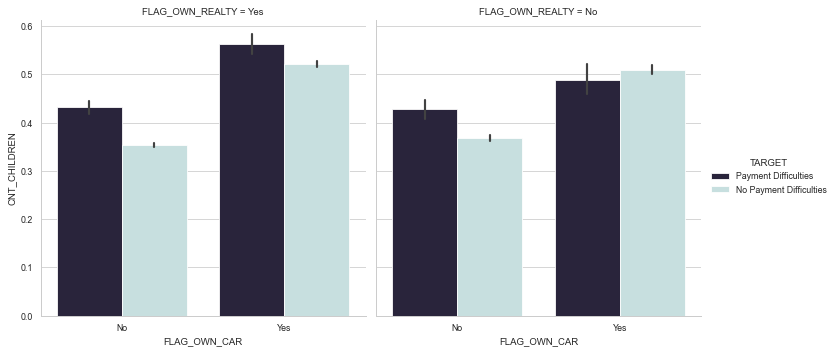

In [ ]:
sns.catplot(x = 'FLAG_OWN_CAR',
            y = 'CNT_CHILDREN', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)
plt.show()

Clients who **own a car** and a **house/flat** have a problem repaying the loans for a high number of children compared to clients who do not own houses/flat.

**2. Income Type, Amount of Goods Price, Target, and House/Flat Ownership Status**

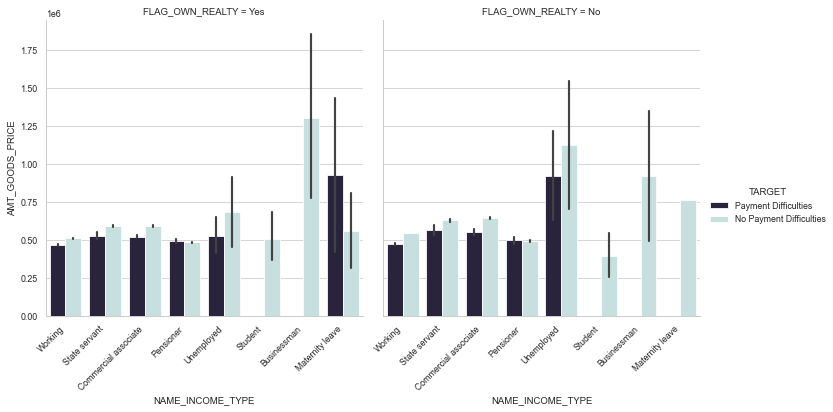

In [ ]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_GOODS_PRICE', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Clients with income type of **maternity leave** in `FLAG_OWN_REALTY` = Yes (i.e own a house/flat) have a problem repaying the loans compared to when `FLAG_OWN_REALTY` = No (i.e not own a house/flat).

**3. Family Status, Amount of Income, Target, and House/Flat Ownership Status**

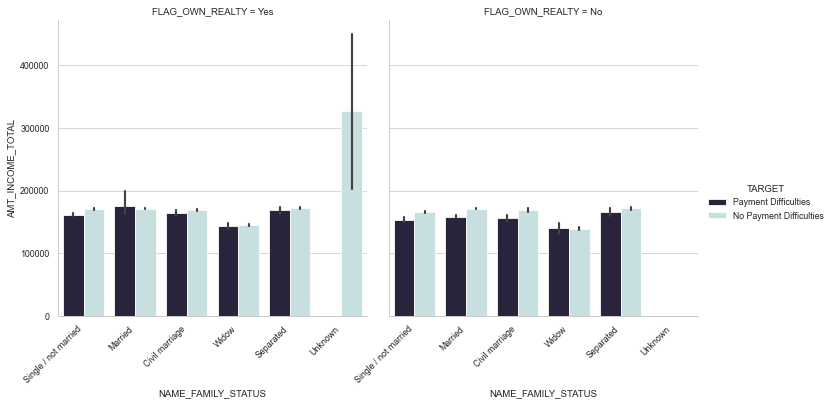

In [ ]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_INCOME_TOTAL', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
#train.groupby(by=['NAME_FAMILY_STATUS','FLAG_OWN_REALTY', 'TARGET'], as_index=False)['AMT_INCOME_TOTAL'].mean()

Clients who are **married** and **own a house/flat** (`FLAG_OWN_REALTY` = Yes) have problem repaying the loans for a medium amount of income compared to when client not own a house/flat (`FLAG_OWN_REALTY` = No).

##### Grouped by Car Ownership Status

**1. Contract Type, The Number of Children, Target, and Car Ownership Status**

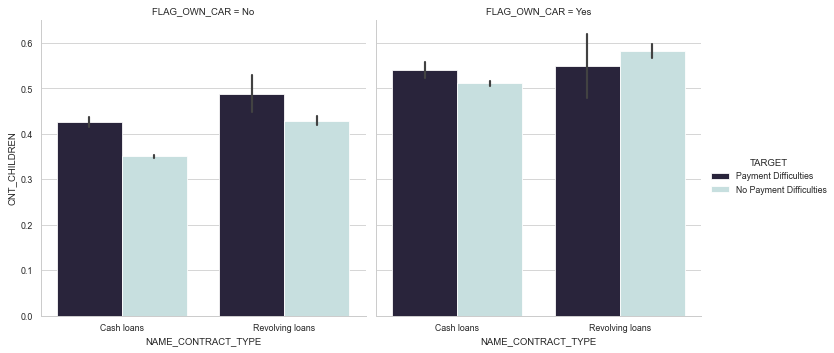

In [ ]:
sns.catplot(x = 'NAME_CONTRACT_TYPE',
            y = 'CNT_CHILDREN', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_CAR', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)
plt.show()

For **revolving loans** in `FLAG_OWN_CAR` = No (i.e not own a car) have problem repaying the loans compared to when `FLAG_OWN_CAR` = Yes (i.e own a car).

##### Grouped by Contract Type

**1. Income Type, Amount of Credit, Target, and Contract Type**

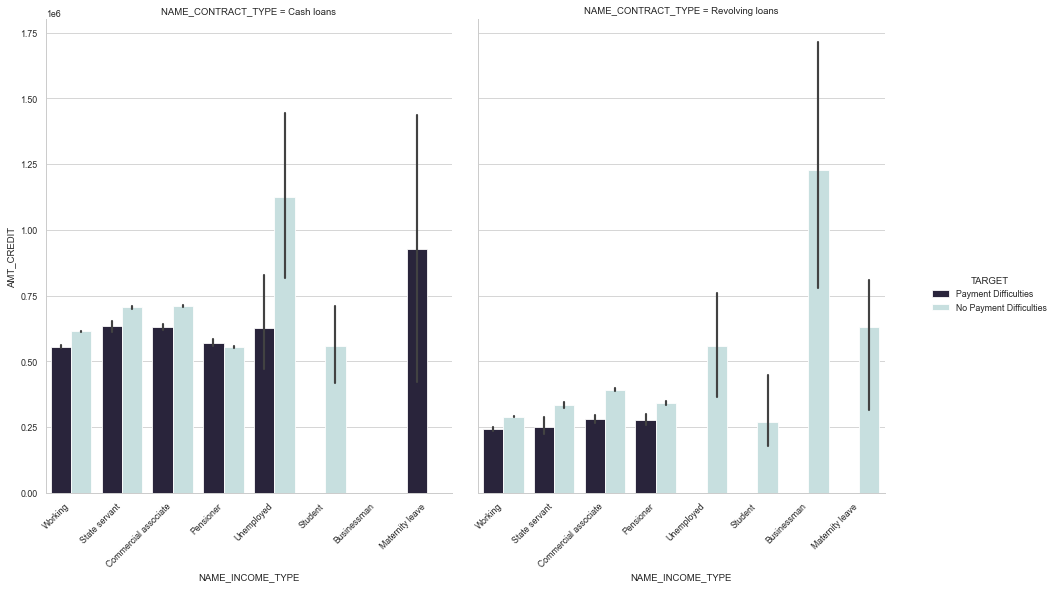

In [ ]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'NAME_CONTRACT_TYPE', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.gcf().set_size_inches(15, 8)
plt.show()

In [ ]:
#train.groupby(by=['NAME_INCOME_TYPE','NAME_CONTRACT_TYPE', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
#train.groupby(by=['NAME_INCOME_TYPE','NAME_CONTRACT_TYPE', 'TARGET'], as_index=False)['AMT_CREDIT'].mean()

For the income type of **maternity leave** with **cash loans**, all the clients have problems repaying the loans for a medium credit amount of the loan. While all clients with maternity leaves and revolving loans have no difficulty repaying the loans.

For **unemployed** clients with **cash loans**, more than 50% of clients have problems repaying loans with medium credit amounts of the loan. While all unemployed clients with revolving loans have no difficulty repaying the loan.

All **student** clients have no difficulty repaying the loans either with cash loan or revolving loan for a low to medium credit amount of the loan.

##### Grouped by Rating of Region where Client Lives

**1. Housing Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives**

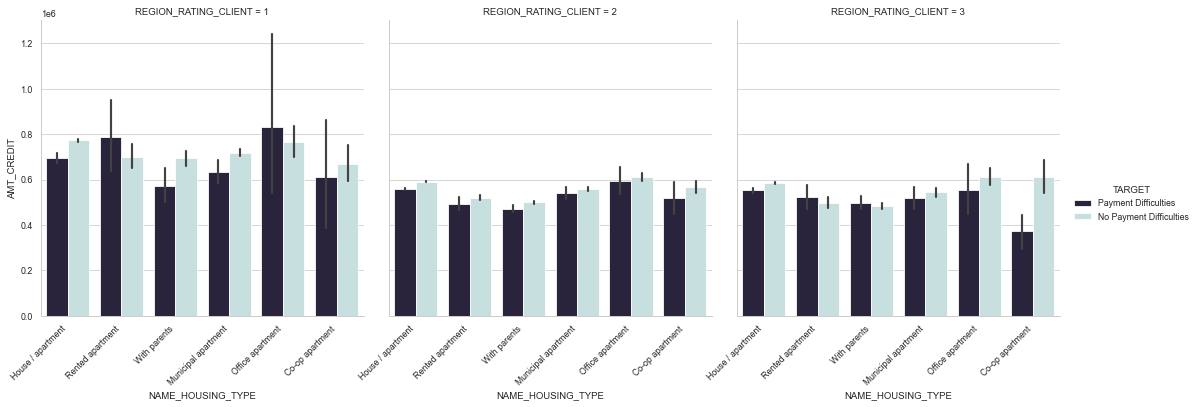

In [ ]:
fig = sns.catplot(x = 'NAME_HOUSING_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Clients who lives in **rented apartment** and **office apartment** and their region have a rating of 1, have a problem repaying the loans compared to client in region with rating of 2 for a medium credit amount of the loan.

**2. Education Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives**

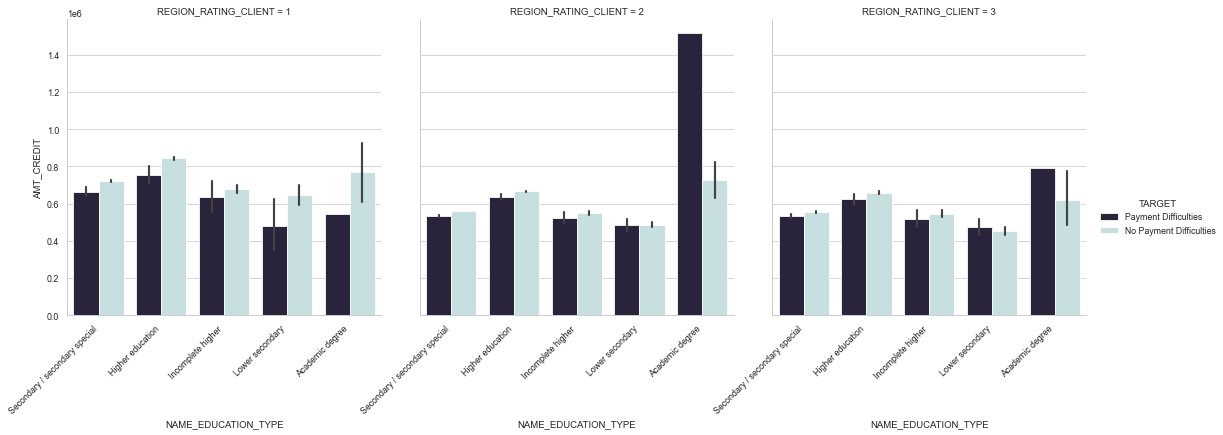

In [ ]:
fig = sns.catplot(x = 'NAME_EDUCATION_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

For client who have **academic degree** and lives in region with **rating of 2**, have a problem repaying the loans for higher amount credit of the loan. And, client with the same degree but lives in region with rating of 3 have problem repaying the loans for a medium amount credit of the loan.

**3. Family Status, Amount Credit of Loan, Target, and Rating of Region where Client Lives**

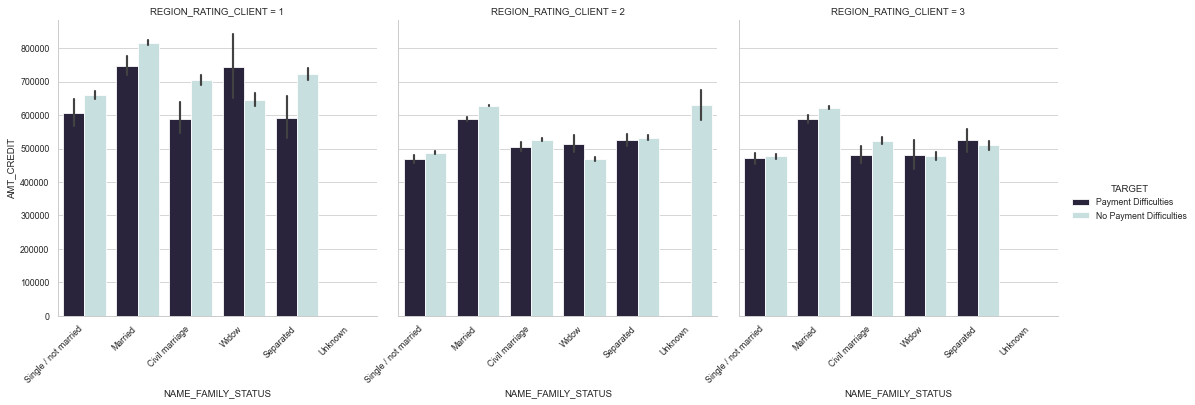

In [ ]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
#train.groupby(by=['NAME_FAMILY_STATUS','REGION_RATING_CLIENT', 'TARGET'], as_index=False)['AMT_CREDIT'].mean()

Clients who have a family status as **widow**, whether they live in a region with a rating of 1, 2, or 3, have problems repaying loans for moderate to high amounts credit of the loan.

Clients who have a family status as **separated**, and live in region with a rating of 3, have problems repaying loans for a moderate amount credit of the loan compared to the clients who live in region with rating of 1 or 2.

## Data Cleaning

### Detecting Data Duplication

In [ ]:
print('The number of duplication is:', df.duplicated().sum())
# there is no duplication

The number of duplication is: 0


### Detecting Missing Values

In [ ]:
# check for empty elements
print('Missing values status:', df.isnull().values.any())
nvc = pd.DataFrame(df.isnull().sum(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,COMMONAREA_MEDI,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MODE,214865,69.872297
3,NONLIVINGAPARTMENTS_MODE,213514,69.432963
4,NONLIVINGAPARTMENTS_AVG,213514,69.432963
5,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
6,FONDKAPREMONT_MODE,210295,68.386172
7,LIVINGAPARTMENTS_MODE,210199,68.354953
8,LIVINGAPARTMENTS_AVG,210199,68.354953
9,LIVINGAPARTMENTS_MEDI,210199,68.354953


In [36]:
# drop features that have large number of missing values (± 50%)
df.drop(df.iloc[:, 44:91], inplace=True, axis=1)
df.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [37]:
# after drop some features
print('Missing values status:', df.isnull().values.any())
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,96391,31.345545
1,EXT_SOURCE_3,60965,19.825307
2,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
3,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.501631
4,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
5,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.501631
6,AMT_REQ_CREDIT_BUREAU_MON,41519,13.501631
7,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.501631
8,NAME_TYPE_SUITE,1292,0.420148
9,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.332021


C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

<AxesSubplot:xlabel='AMT_REQ_CREDIT_BUREAU_DAY', ylabel='Density'>

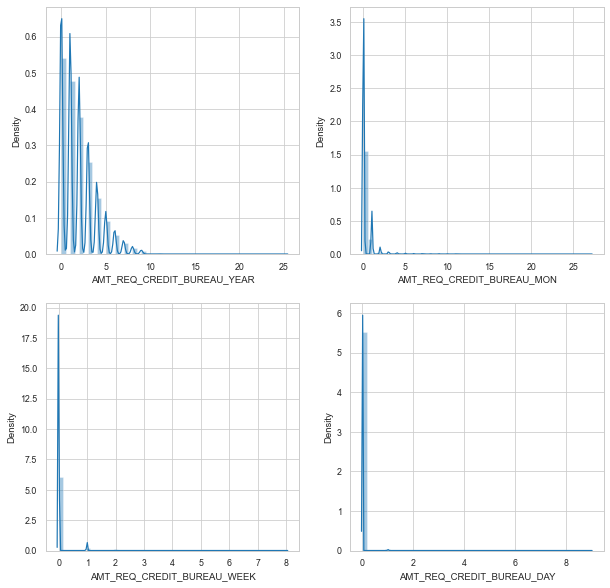

In [ ]:
# distribution of numerical features that have missing values pt.1
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_YEAR'], ax=ax[0][0])

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_MON'], ax=ax[0][1])

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_WEEK'], ax=ax[1][0])

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_DAY'], ax=ax[1][1])

C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

<AxesSubplot:xlabel='AMT_ANNUITY', ylabel='Density'>

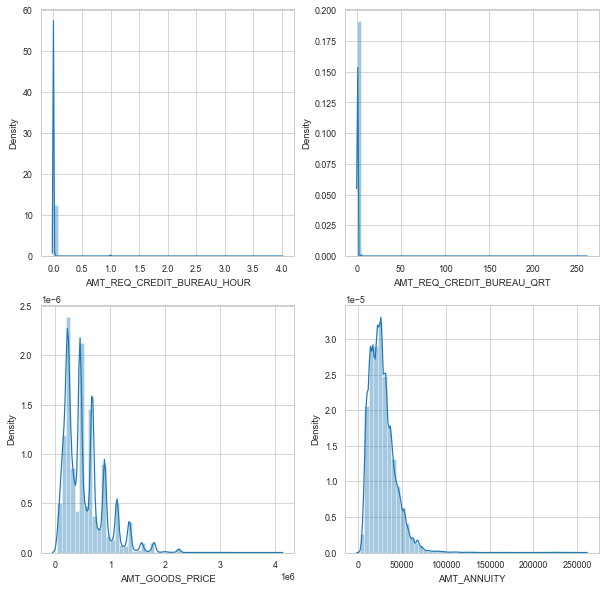

In [ ]:
# distribution of numerical features that have missing values pt.2
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_HOUR'], ax=ax[0][0])

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_QRT'], ax=ax[0][1])

sns.distplot(df['AMT_GOODS_PRICE'], ax=ax[1][0])

sns.distplot(df['AMT_ANNUITY'], ax=ax[1][1])

C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

<AxesSubplot:xlabel='OBS_30_CNT_SOCIAL_CIRCLE', ylabel='Density'>

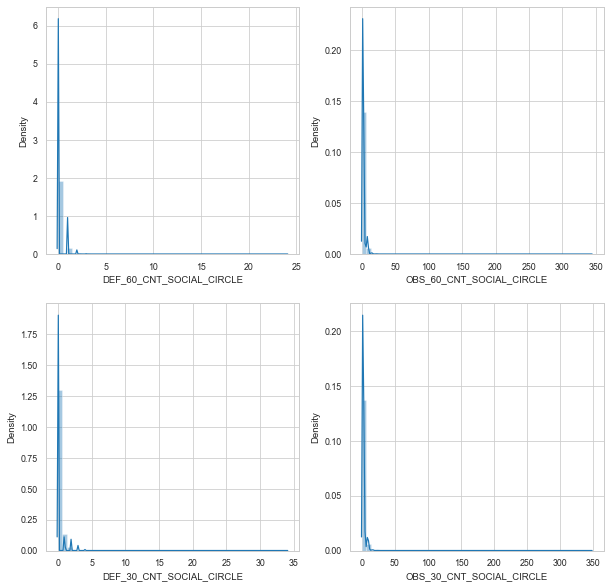

In [ ]:
# distribution of numerical features that have missing values pt.3
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df['DEF_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][0])

sns.distplot(df['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][1])

sns.distplot(df['DEF_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][0])

sns.distplot(df['OBS_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][1])

C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DAYS_LAST_PHONE_CHANGE', ylabel='Density'>

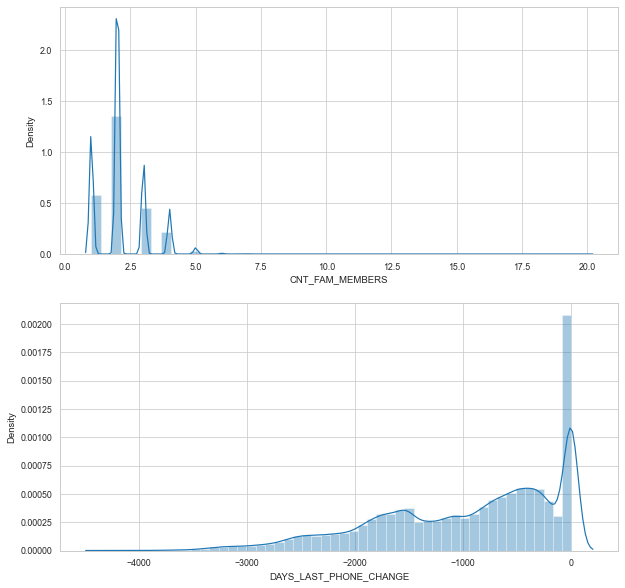

In [ ]:
# distribution of numerical features that have missing values pt.3
sns.set_style('whitegrid')
fig, ax = plt.subplots(2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df['CNT_FAM_MEMBERS'], ax=ax[0])

sns.distplot(df['DAYS_LAST_PHONE_CHANGE'], ax=ax[1])

It can be seen that the distribution of numerical features that mentioned above is skewed, so the missing values in those features will be imputed with the median.

In [38]:
# impute missing values with median because the data is skewed for numerical features
# impute missing values with mode for categorical features

category_columns = df.select_dtypes(include=['object']).columns.tolist()
integer_columns = df.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df:
    if df[column].isnull().any():
        if(column in category_columns):
            df[column]=df[column].fillna(df[column].mode()[0])
        else:
            df[column]=df[column].fillna(df[column].median())

In [39]:
# after imputation
print('Missing values status:', df.isnull().values.any())
print('\nThe number of missing values for each columns (after imputation): \n')
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False

The number of missing values for each columns (after imputation): 



,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,REG_REGION_NOT_WORK_REGION,0,0.0
2,REGION_POPULATION_RELATIVE,0,0.0
3,AMT_INCOME_TOTAL,0,0.0
4,TARGET,0,0.0
5,NAME_CONTRACT_TYPE,0,0.0
6,CODE_GENDER,0,0.0
7,FLAG_OWN_CAR,0,0.0
8,FLAG_OWN_REALTY,0,0.0
9,CNT_CHILDREN,0,0.0


### Detecting Outliers

In [40]:
# dataset that only consist numerical features pt.1
int_features = df[["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]]

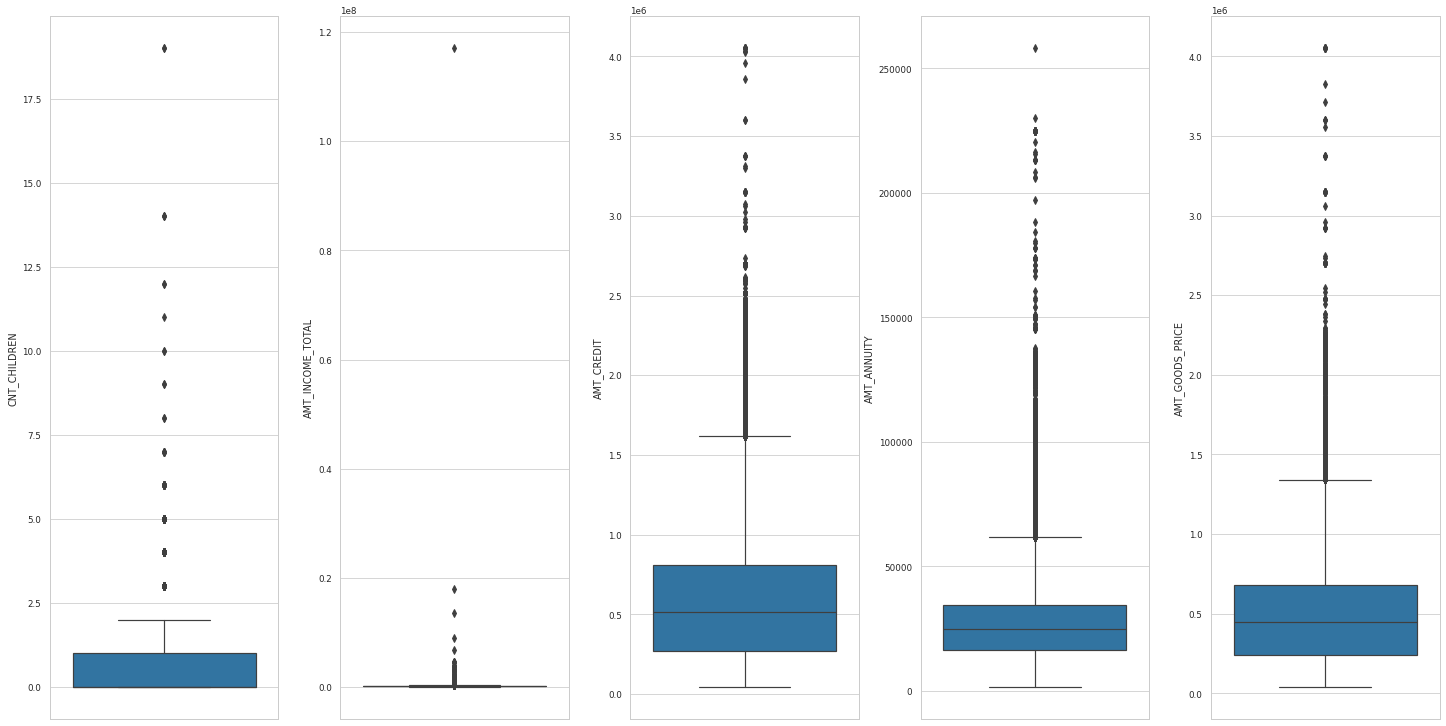

In [41]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [42]:
# dataset that only consist numerical features pt.2
int_features = df[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "CNT_FAM_MEMBERS"]]

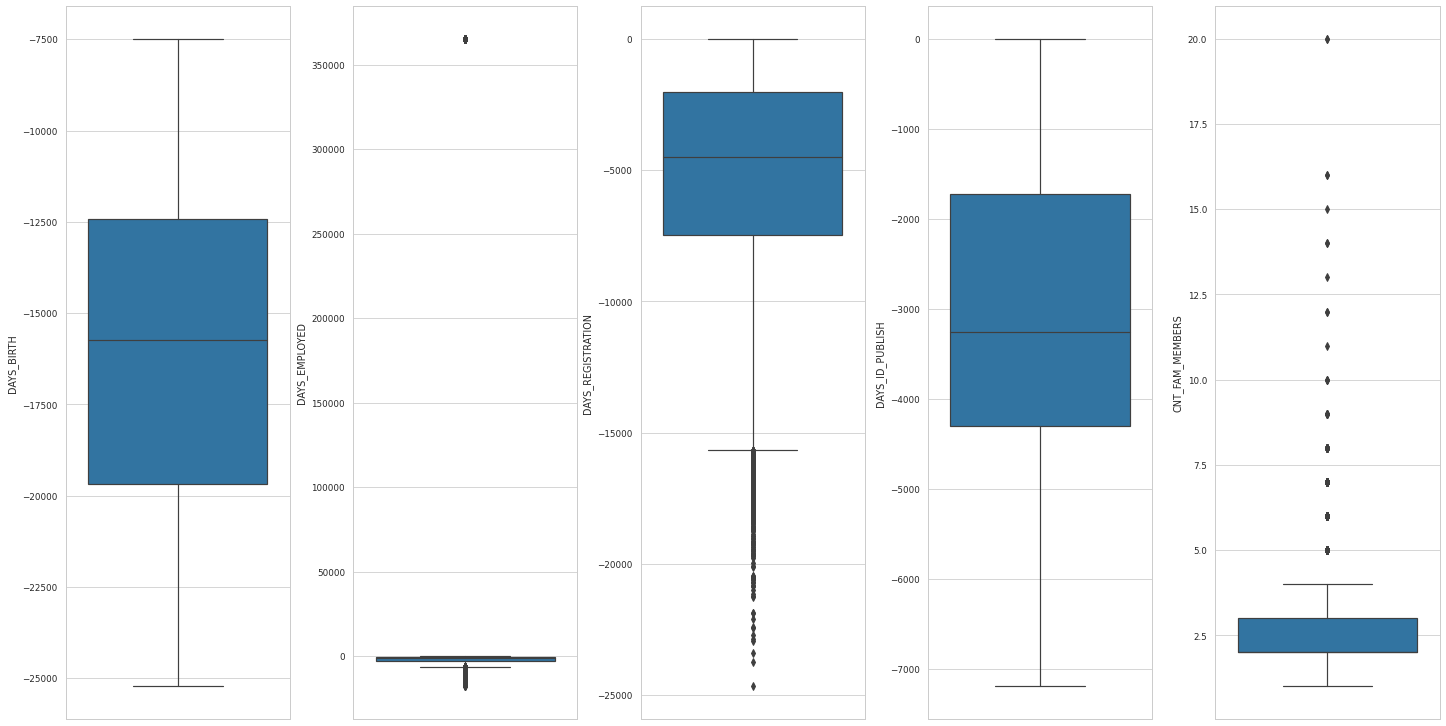

In [43]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [44]:
# dataset that only consist numerical features pt.3
int_features = df[["AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_HOUR"]]

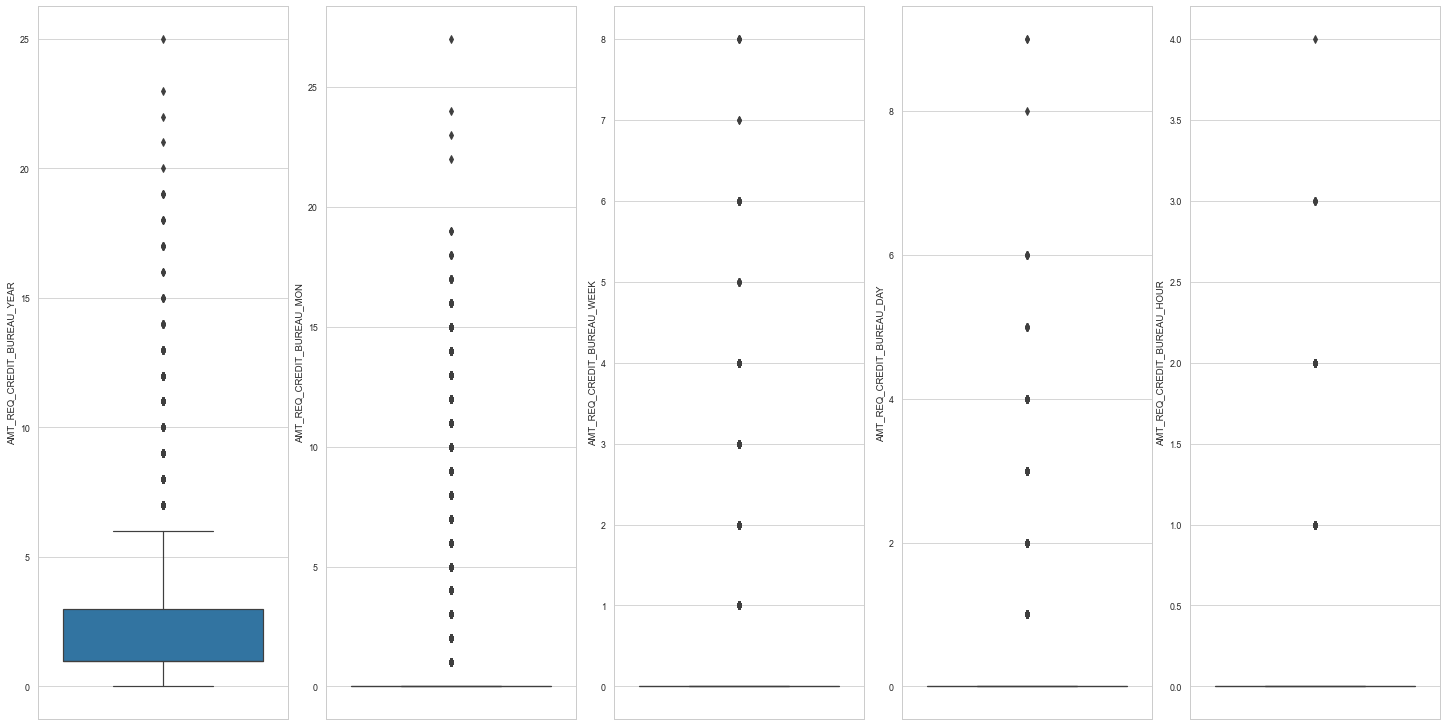

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
# dataset that only consist numerical features pt.4
int_features = df[["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "REGION_POPULATION_RELATIVE"]]

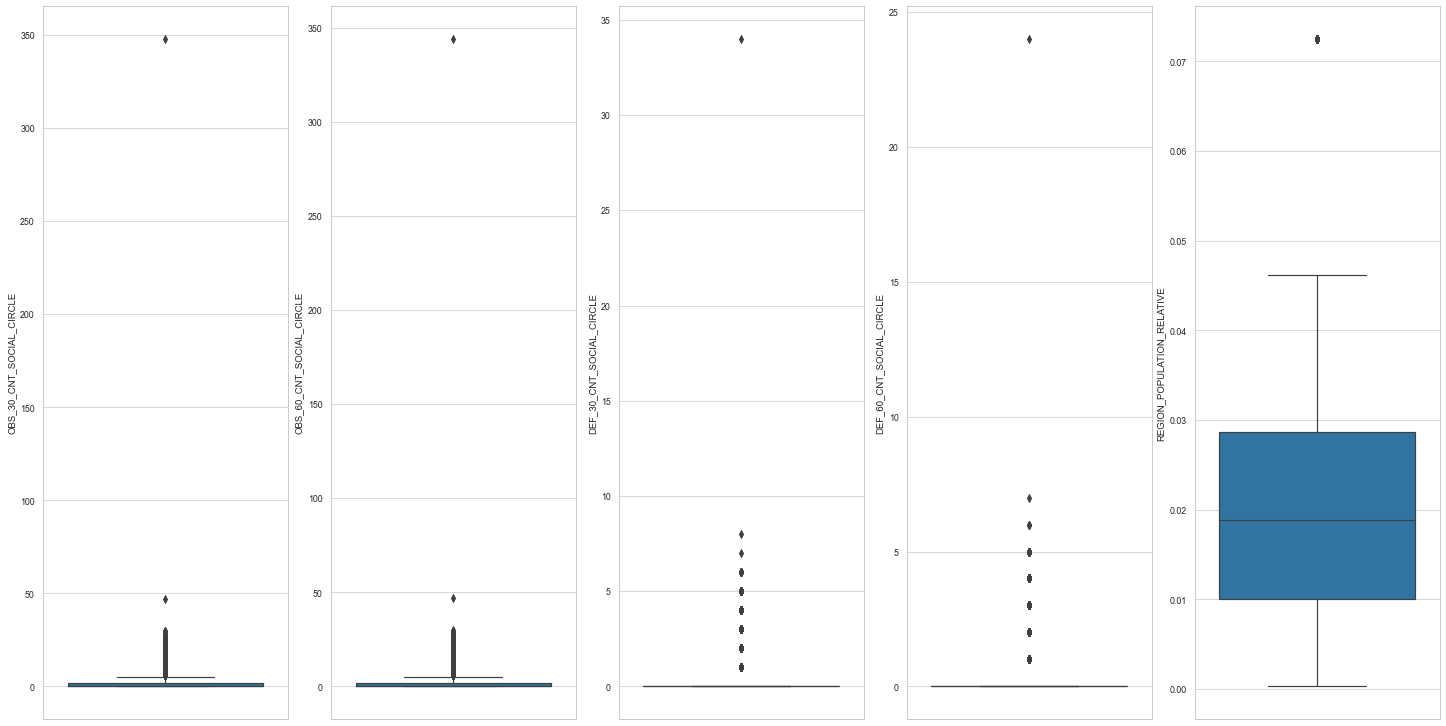

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
# dataset that only consist numerical features pt.5
int_features = df[["REGION_RATING_CLIENT", "HOUR_APPR_PROCESS_START", "DAYS_LAST_PHONE_CHANGE", "FLAG_DOCUMENT_2", "AMT_REQ_CREDIT_BUREAU_QRT"]]

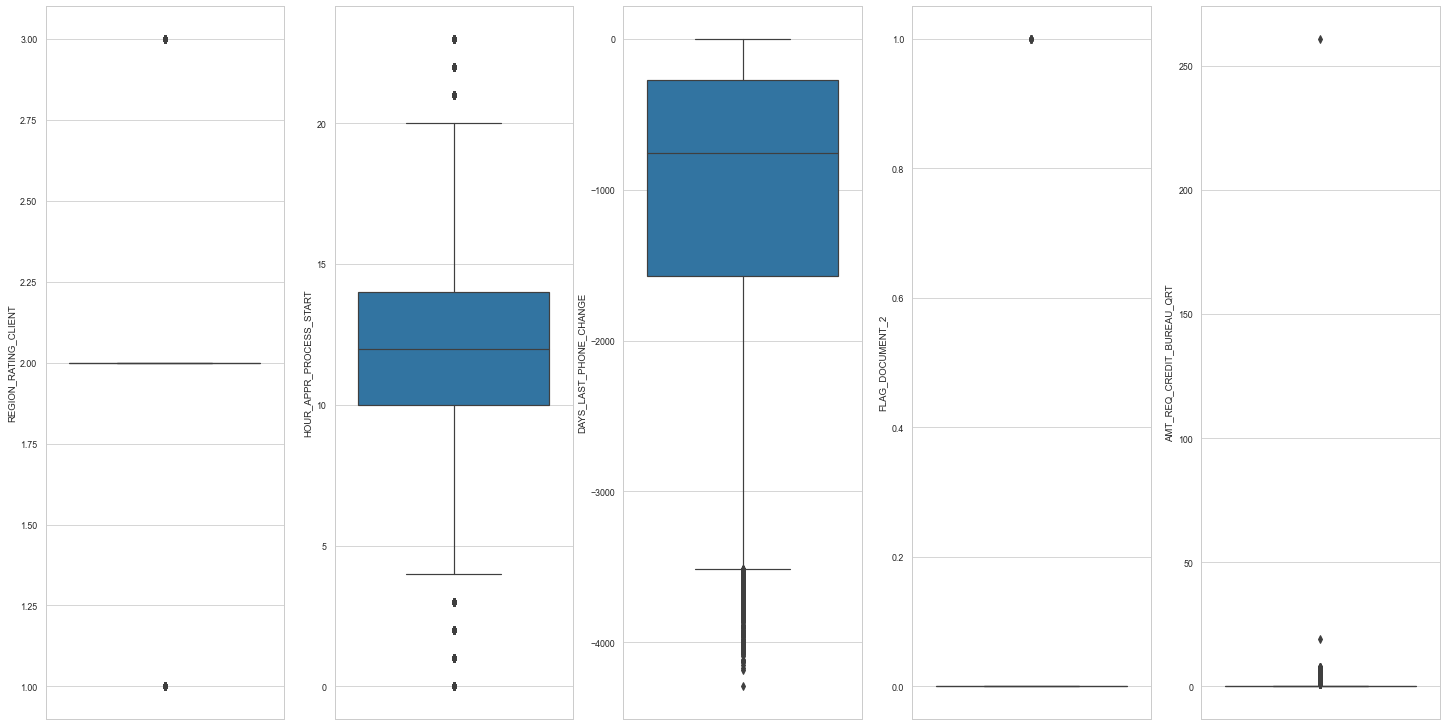

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Outliers on the numerical features mentioned above will not be removed because there may be insights that can be drawn from these outliers.

## Machine Learning Models

### Label Encoding

In [45]:
# label encoder for object features
df[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [ ]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,5,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,1,1,37,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Selection

#### Drop Unnecessary Feature

In [46]:
df.drop(['SK_ID_CURR'], inplace=True, axis=1)

In [ ]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,5,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,1,1,37,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Convert Negative Values to Positive Values

The features that have negative values are `DAYS_BIRTH`, `DAYS_EMPLOYED`, `DAYS_ID_PUBLISH`, `DAYS_REGISTRATION`, and `DAYS_LAST_PHONE_CHANGE`

In [47]:
df.iloc[:,16:20] = df.iloc[:,16:20].abs()
df.iloc[:,45] = df.iloc[:,45].abs()

#### Feature Selection

In [48]:
x = df.drop(['TARGET'], axis=1)
y = df['TARGET']

In [49]:
# feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print('The features that correlate well with target feature:\n')
featureScores.sort_values(by=['Score'], ascending=False)

The features that correlate well with target feature:



,Features,Score
16,DAYS_EMPLOYED,1.954124e+08
8,AMT_GOODS_PRICE,1.223080e+08
6,AMT_CREDIT,7.669987e+07
15,DAYS_BIRTH,2.235391e+06
5,AMT_INCOME_TOTAL,1.624102e+06
17,DAYS_REGISTRATION,1.348566e+06
44,DAYS_LAST_PHONE_CHANGE,6.656876e+05
18,DAYS_ID_PUBLISH,6.195946e+05
7,AMT_ANNUITY,3.913092e+05
37,ORGANIZATION_TYPE,4.138607e+03


It can be seen which features correlate well with payment difficulties.

1. **Best features**: `DAYS_EMPLOYED`, `AMT_GOODS_PRICE`, and `AMT_CREDIT`

2. **Worst features**: `FLAG_MOBIL`, `FLAG_CONT_MOBILE`, and `AMT_REQ_CREDIT_BUREAU_HOUR`

### Handling Data Imbalance

In [50]:
# create two different dataframe of majority and minority class 
df_majority = df[(df['TARGET']==0)] 
df_minority = df[(df['TARGET']==1)] 

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 282686, # to match majority class
                                 random_state=42)  # reproducible results

# combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

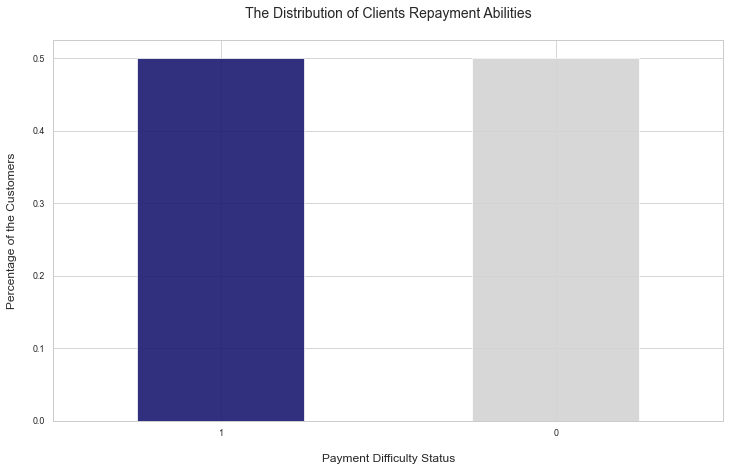

In [ ]:
fig = plt.figure(figsize = (12,7))
df_upsampled['TARGET'].value_counts(normalize=True).plot(kind='bar', color= ['midnightblue','lightgrey'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.ylabel('Percentage of the Customers\n', fontsize=12)
plt.xlabel('\nPayment Difficulty Status', fontsize=12)
plt.show()

It can be seen that the data is balanced, so the analysis can be continued.

### **Data Splitting**

In [51]:
# define x and y features (top 20 features)
x_balanced = df_upsampled[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
y_balanced = df_upsampled['TARGET']

In [52]:
# splitting tha data
X_train, X_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(452297, 20) (113075, 20)


In [53]:
# normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model Building

Here are some algorithms that will be tested to determine the best model:
1. Logistic Regression
3. Decision Tree
4. Random Forest


#### 1. Logistic Regression

In [54]:
# train the model
log_model = LogisticRegression().fit(X_train, y_train)
print(log_model)

LogisticRegression()


In [55]:
# predict data train
y_train_pred_log = log_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Logistic Regression):')
print(classification_report(y_train, y_train_pred_log))

Classification Report Training Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68    226185
           1       0.68      0.66      0.67    226112

    accuracy                           0.67    452297
   macro avg       0.67      0.67      0.67    452297
weighted avg       0.67      0.67      0.67    452297



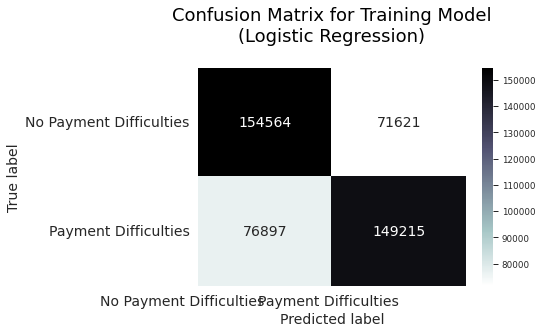

In [58]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_train, y_train_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [59]:
# predict data test
y_test_pred_log = log_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred_log))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     56501
           1       0.68      0.66      0.67     56574

    accuracy                           0.67    113075
   macro avg       0.67      0.67      0.67    113075
weighted avg       0.67      0.67      0.67    113075



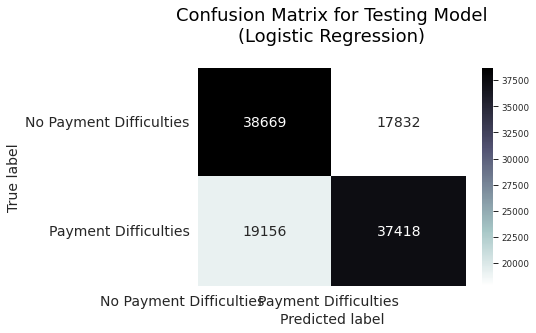

In [60]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_test, y_test_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [61]:
acc_log_train=round(log_model.score(X_train,y_train)*100,2)
acc_log_test=round(log_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Test Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 67.16
Test Accuracy: % 67.29


It can be seen that:
- Logistic regression model gives 67.16% correct results.
- There is 0.13% error margin.

In [62]:
# ROC scores
roc_auc_log = round(roc_auc_score(y_test, y_test_pred_log),4)
print('ROC AUC:', roc_auc_log)

ROC AUC: 0.6729


#### 2. Decision Tree

In [63]:
# train the model
dt_model = DecisionTreeClassifier().fit(X_train,y_train)
print(dt_model)

DecisionTreeClassifier()


In [64]:
# predict data train
y_train_pred_dt = dt_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



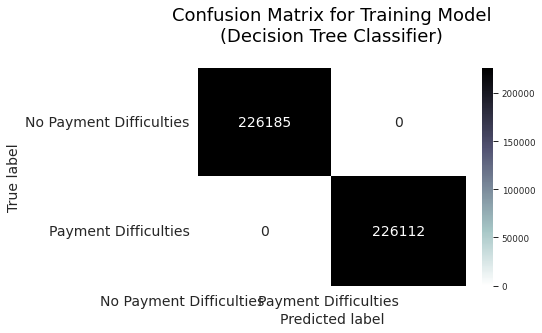

In [65]:
# form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [66]:
# predict data test
y_test_pred_dt = dt_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Decision Tree Classifier):')
print(classification_report(y_test, y_test_pred_dt))

Classification Report Testing Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     56501
           1       0.90      0.86      0.88     56574

    accuracy                           0.88    113075
   macro avg       0.88      0.88      0.88    113075
weighted avg       0.88      0.88      0.88    113075



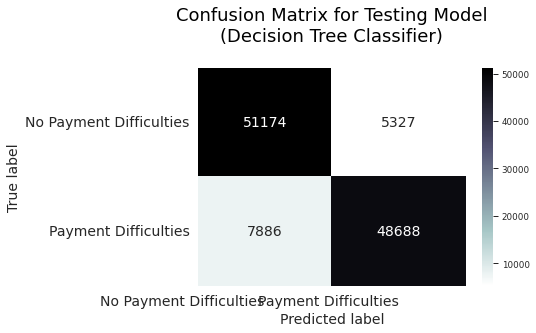

In [67]:
# form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_test, y_test_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [68]:
acc_dt_train=round(dt_model.score(X_train,y_train)*100,2)
acc_dt_test=round(dt_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_dt_train))
print("Test Accuracy: % {}".format(acc_dt_test))

Training Accuracy: % 100.0
Test Accuracy: % 88.31


It can be seen that:
- Decision tree model gives 100% correct results.
- There is 11.74% error margin. This is not good for this data.

In [69]:
# ROC scores
roc_auc_dt = round(roc_auc_score(y_test, y_test_pred_dt),4)
print('ROC AUC:', roc_auc_dt)

ROC AUC: 0.8832


#### 3. Random Forest

In [70]:
# train the model
rf_model = RandomForestClassifier().fit(X_train, y_train)
print(rf_model)

RandomForestClassifier()


In [71]:
# predict data train
y_train_pred_dt = rf_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



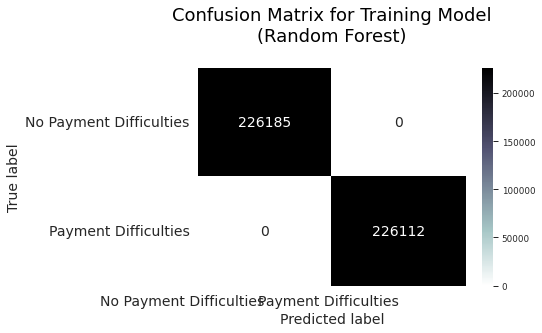

In [72]:
# form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [73]:
# predict data test
y_test_pred_rf = rf_model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report

# print classification report
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred_rf))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56501
           1       0.99      1.00      1.00     56574

    accuracy                           1.00    113075
   macro avg       1.00      1.00      1.00    113075
weighted avg       1.00      1.00      1.00    113075



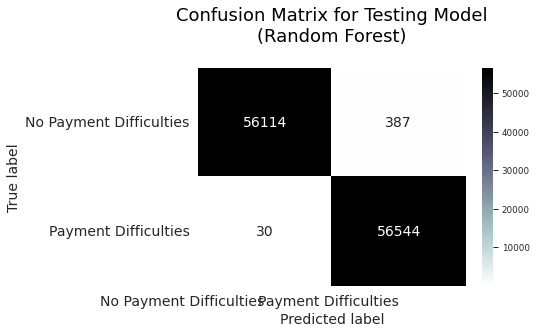

In [74]:
# form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_test, y_test_pred_rf)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [75]:
acc_rf_train=round(rf_model.score(X_train,y_train)*100,2)
acc_rf_test=round(rf_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_rf_train))
print("Test Accuracy: % {}".format(acc_rf_test))

Training Accuracy: % 100.0
Test Accuracy: % 99.63


It can be seen that:
- Random forest model gives 100% correct results.
- There is 0.35% error margin.

In [76]:
# ROC scores
roc_auc_rf = round(roc_auc_score(y_test, y_test_pred_rf),4)
print('ROC AUC:', roc_auc_rf)

ROC AUC: 0.9963


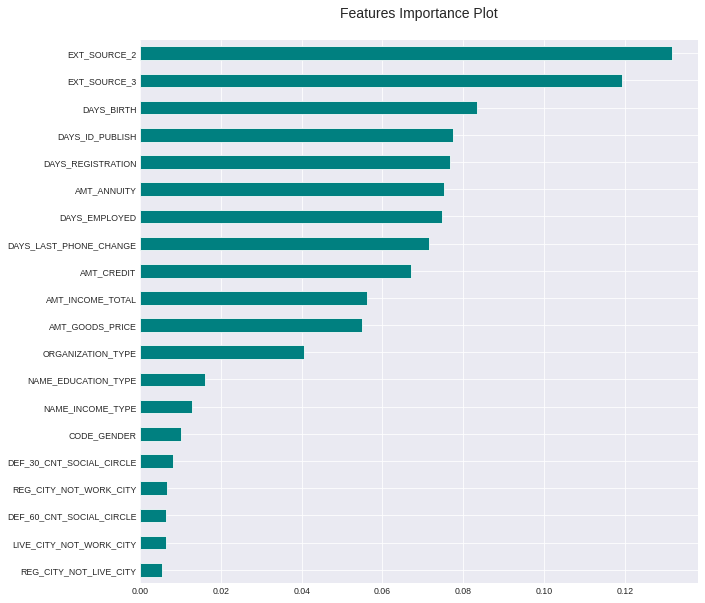

In [77]:
# important features
importances_rf = pd.Series(rf_model.feature_importances_, index=x_balanced.columns).sort_values(ascending=True)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,10))
fig = importances_rf.plot(kind ='barh', color ='teal')
plt.title('Features Importance Plot\n', fontsize=14)
plt.show()

fig.figure.tight_layout()
fig.figure.savefig('top feature.png')

The plot above confirms that the 5 most important features are `EXT_SOURCE_2`, `EXT_SOURCE_3`, `DAYS_BIRTH`, `DAYS_ID_PUBLISH`, and `DAYS_REGISTRATION`

### Model Selection

In [78]:
results = pd.DataFrame([["Logistic Regression", 0.6716, 0.6729, 0.6729],
                       ["Decision Tree", 1, 0.8826, 0.8826],["Random Forest", 1, 0.9965, 0.9965]],
                        columns = ["Models", "Training Accuracy Score", "Testing Accuracy Score", "ROC Score"])

results.sort_values(by=['Training Accuracy Score', 'Testing Accuracy Score'], ascending=False)

,Models,Training Accuracy Score,Testing Accuracy Score,ROC Score
2,Random Forest,1.0000,0.9965,0.9965
1,Decision Tree,1.0000,0.8826,0.8826
0,Logistic Regression,0.6716,0.6729,0.6729


The prediction accuracy of the train and test data in **Random Forest** model has a value that is not much different, it can be said that the model is very good, which is there is **no underfitting or overfitting**. So the Random Forest model was chosen as the **best model to predict client’s repayment abilities**.

## Prediction

### Import Dataset

In [ ]:
# data application (test)
drive.mount('/content/drive')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Home Credit VIX/dataset homecredit/application_test.csv', sep=',' )
print('This dataset has %d rows dan %d columns.\n' % df_test.shape)
df_test.head()

This dataset has 48744 rows dan 121 columns.



,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

There are total 48,744 rows which contains the information of loans and there are 121 features (without target feature).

### Data Preprocessing

#### Detecting Duplication

In [ ]:
print('The number of duplication is:', df_test.duplicated().sum())
# there is no duplication

The number of duplication is: 0


#### Detecting Missing Values

In [ ]:
# check for empty elements
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,COMMONAREA_AVG,33495,68.716150
1,COMMONAREA_MODE,33495,68.716150
2,COMMONAREA_MEDI,33495,68.716150
3,NONLIVINGAPARTMENTS_AVG,33347,68.412523
4,NONLIVINGAPARTMENTS_MODE,33347,68.412523
5,NONLIVINGAPARTMENTS_MEDI,33347,68.412523
6,FONDKAPREMONT_MODE,32797,67.284179
7,LIVINGAPARTMENTS_AVG,32780,67.249302
8,LIVINGAPARTMENTS_MODE,32780,67.249302
9,LIVINGAPARTMENTS_MEDI,32780,67.249302


In [ ]:
# drop features that have large number of missing values (± 50%)
df_test.drop(df_test.iloc[:, 43:90], inplace=True, axis=1)
df_test.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [ ]:
# after drop some features
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,15605,32.014197
1,EXT_SOURCE_3,8668,17.782701
2,AMT_REQ_CREDIT_BUREAU_YEAR,6049,12.409732
3,AMT_REQ_CREDIT_BUREAU_QRT,6049,12.409732
4,AMT_REQ_CREDIT_BUREAU_MON,6049,12.409732
5,AMT_REQ_CREDIT_BUREAU_WEEK,6049,12.409732
6,AMT_REQ_CREDIT_BUREAU_DAY,6049,12.409732
7,AMT_REQ_CREDIT_BUREAU_HOUR,6049,12.409732
8,NAME_TYPE_SUITE,911,1.868948
9,OBS_30_CNT_SOCIAL_CIRCLE,29,0.059495


In [ ]:
# impute missing values with median because the data is skewed for numerical features
# impute missing values with mode for categorical features

category_columns = df_test.select_dtypes(include=['object']).columns.tolist()
integer_columns = df_test.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df_test:
    if df_test[column].isnull().any():
        if(column in category_columns):
            df_test[column]=df_test[column].fillna(df_test[column].mode()[0])
        else:
            df_test[column]=df_test[column].fillna(df_test[column].median())

In [ ]:
# after imputation
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False


,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,NAME_CONTRACT_TYPE,0,0.0
2,FLAG_DOCUMENT_8,0,0.0
3,FLAG_DOCUMENT_7,0,0.0
4,FLAG_DOCUMENT_6,0,0.0
5,FLAG_DOCUMENT_5,0,0.0
6,FLAG_DOCUMENT_4,0,0.0
7,FLAG_DOCUMENT_3,0,0.0
8,FLAG_DOCUMENT_2,0,0.0
9,DAYS_LAST_PHONE_CHANGE,0,0.0


#### Label Encoding

In [ ]:
# label encoder for object features
df_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [ ]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,6,6,1,1,1,0.018850,-19241,-2329,-5170.0,-812,1,1,0,1,0,1,8,2.0,2,2,5,18,0,0,0,0,0,0,28,0.789654,0.159520,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,6,6,4,1,1,0.035792,-18064,-4469,-9118.0,-1623,1,1,0,1,0,0,9,2.0,2,2,0,9,0,0,0,0,0,0,42,0.291656,0.432962,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,6,6,1,1,1,0.019101,-20038,-4458,-2175.0,-3503,1,1,0,1,0,0,4,2.0,2,2,1,14,0,0,0,0,0,0,54,0.699787,0.610991,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,6,6,4,1,1,0.026392,-13976,-1866,-2000.0,-4208,1,1,0,1,1,0,14,4.0,2,2,6,11,0,0,0,0,0,0,5,0.509677,0.612704,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,6,6,4,1,1,0.010032,-13040,-2191,-4000.0,-4262,1,1,1,1,0,0,8,3.0,2,2,0,5,0,0,0,0,1,1,5,0.425687,0.519097,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


#### Convert Negative Values to Positive Values

The features that have negative values are `DAYS_BIRTH`, `DAYS_EMPLOYED`, `DAYS_ID_PUBLISH`, and `DAYS_REGISTRATION`, `DAYS_LAST_PHONE_CHANGE`

In [ ]:
df_test.iloc[:,16:20] = df_test.iloc[:,16:20].abs()
df_test.iloc[:,45] = df_test.iloc[:,45].abs()

### Prediction

Predict client's repayment abilities on application data test with best machine learning model obtained before, i.e **Random Forest**.

In [ ]:
pred_test = df_test[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
pred_test.head()

,DAYS_EMPLOYED,AMT_GOODS_PRICE,AMT_CREDIT,DAYS_BIRTH,AMT_INCOME_TOTAL,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,AMT_ANNUITY,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,CODE_GENDER,EXT_SOURCE_2,REG_CITY_NOT_LIVE_CITY,NAME_EDUCATION_TYPE,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_3,DEF_60_CNT_SOCIAL_CIRCLE,LIVE_CITY_NOT_WORK_CITY
0,2329,450000.0,568800.0,19241,135000.0,5170.0,1740.0,812,20560.5,28,6,0,0,0.789654,0,1,0.0,0.159520,0.0,0
1,4469,180000.0,222768.0,18064,99000.0,9118.0,0.0,1623,17370.0,42,6,0,1,0.291656,0,4,0.0,0.432962,0.0,0
2,4458,630000.0,663264.0,20038,202500.0,2175.0,856.0,3503,69777.0,54,6,0,1,0.699787,0,1,0.0,0.610991,0.0,0
3,1866,1575000.0,1575000.0,13976,315000.0,2000.0,1805.0,4208,49018.5,5,6,0,0,0.509677,0,4,0.0,0.612704,0.0,0
4,2191,625500.0,625500.0,13040,180000.0,4000.0,821.0,4262,32067.0,5,6,1,1,0.425687,0,4,0.0,0.519097,0.0,1


In [ ]:
# lets predict!
predict = pd.Series(rf_model.predict(pred_test), name = "TARGET").astype(int)
results = pd.concat([df_test['SK_ID_CURR'], predict],axis = 1)
results.to_csv("predict application.csv", index = False)
results.head()

C:\Users\USER KEMENDIKBUD\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


## Recommendation

1. Create a campaign so that more student, accountant, high skill tech staff, manager interested in applying for a loan
2. Need further analysis, you can survey to find out if there is a problem if a client with maternity leaves or unemployed takes a cash loans contract. So, in the future, if there are clients with that type of income, you can recommend the right contract type so that their applications will be approved
3. Clients who have no payment difficulties are clients in the range of 35-45 years. You can target these clients as your priority.